In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geoist as gi
import torch
import argparse
import encoder
import decoder
import discriminator

[Errno 17] File exists: '/home/liyongbo/.local/share/geoist'
[Errno 17] File exists: '/home/liyongbo/.local/share/geoist/examples'
[Errno 17] File exists: '/home/liyongbo/.local/share/geoist/temp'
[Errno 17] File exists: '/home/liyongbo/.local/share/geoist/data'


In [10]:
def load_args():
    parser = argparse.ArgumentParser(description='gangravity')
    parser.add_argument('-c', '--checkpoint', default='./models/checkpointSH_withnoise_500m.pt',
                        type=str, help='checkpoint file')
    parser.add_argument('-d', '--device', default='cuda:2', type=str, help='computing device')
    parser.add_argument('-l', '--gp', default=10, type=int, help='gradient penalty')
    parser.add_argument('-g', '--n_gp', default=1, type=int)
    parser.add_argument('-b', '--batch_size', default=1, type=int)
    parser.add_argument('-n', '--n_batch', default=150, type=int)
    parser.add_argument('-e', '--epochs', default=100, type=int)
    parser.add_argument('-w', '--world_size', default=3, type=int)
    parser.add_argument('--use_spectral_norm', default=False)
    args =parser.parse_known_args()[0]
    return args

def load_models(args, checkpoint=None):
    netDec = decoder.GravDecoder()
    netDis = discriminator.GravDiscriminator()
    netEnc = encoder.GravEncoder()
    netEnc = netEnc.to(args.device)
    if checkpoint:
        netEnc.load_state_dict(checkpoint['enc_state_dict'])
        netDis.load_state_dict(checkpoint['dis_state_dict'])
    print (netDec, netDis, netEnc)
    return (netDec, netDis, netEnc)
args_gen = load_args()
checkpoint = torch.load(args_gen.checkpoint)
saved_model = ['enc_state_dict','dis_state_dict']
for model_key in saved_model:
    new_keys = list(map(lambda x:x[7:],checkpoint[model_key].keys()))
    checkpoint[model_key] = dict(zip(new_keys,list(checkpoint[model_key].values())))
netDec,netDis,netEnc = load_models(args_gen, checkpoint)
netEnc.eval()

GravDecoder() GravDiscriminator(
  (conv3d_x): ModuleList(
    (0): Conv3d(1, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): Conv3d(1, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (2): Conv3d(1, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  )
  (conv3d_y): ModuleList(
    (0): Conv3d(1, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): Conv3d(1, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (2): Conv3d(1, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  )
  (conv3d_z): ModuleList(
    (0): Conv3d(1, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): Conv3d(1, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (2): Conv3d(1, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  )
  (linear_x): Conv3d(1, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (linear_y): Conv3d(1, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (linear_z): Conv3d(1, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1))
) GravEncoder(
  (pre_conv_layers): ModuleList(
    (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), p

GravEncoder(
  (pre_conv_layers): ModuleList(
    (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (2): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (pre_norm_layers): ModuleList(
    (0): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, af

In [16]:
dummy_input = torch.randn(1, 1, 64, 64)
dummy_input = dummy_input.to(device=args_gen.device)
torch.onnx.export(netEnc, (dummy_input, ), 'model_antinoise.onnx')

In [11]:
with torch.no_grad():
        modeltest = 'realdata.npy'
        #testfile = os.path.join(os.getcwd(), 'Verifydatasets', "models", modeltest)
        data = np.load(modeltest)
        input_data = data
        dain = data
        input_data = input_data.reshape(1, 64, 64)

        input_data = torch.from_numpy(input_data)
        input_data = input_data.type(torch.FloatTensor)
        input_data = input_data.unsqueeze(0).to(args_gen.device)
        density_rec = netEnc(input_data)
        rec = density_rec.squeeze(0)
        rec = rec.cpu().numpy()
        rec = rec.reshape(64, 64)
        #np.save('realdata000m.npy', np.array(rec))
        print('Done')

Done


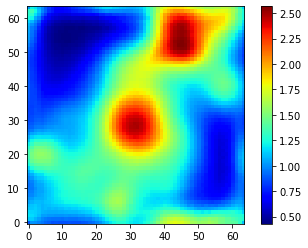

In [13]:
plt.imshow(rec.T, origin='lower',cmap='jet')
plt.colorbar()

Comparison for the downward continuation method!


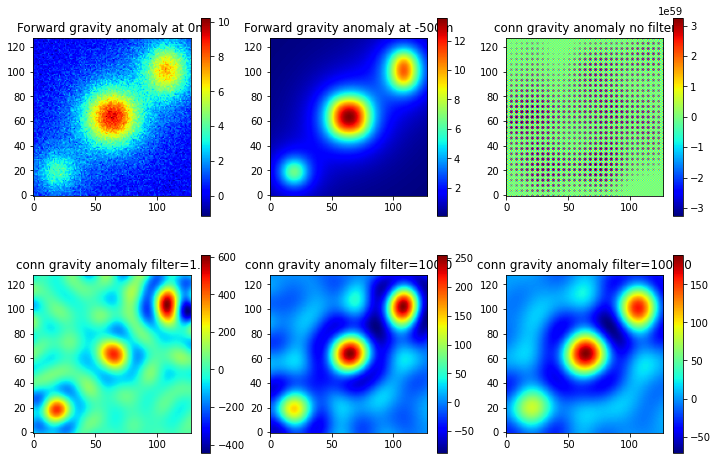

In [15]:
# -*- coding: utf-8 -*-
"""
Created on Mon May 30 21:05:07 2022
计算岩石圈磁场X，Y，Z矢量：

MF7 crustal field model with 16-133 degress卫星岩石圈磁场模型
CHAOS6 crustal field model with 21-110 degress
NGDC720 crustal field model with 16-720 degress (>120)卫星岩石圈磁场模型

注：支持SHC格式和COF格式的球谐系数解算
@author: chens
"""
from numpy import array, stack
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from geoist import gridder
from geoist.inversion import geometry
from geoist.pfm import prism,pftrans
from geoist.vis import giplt
from geoist.pfm import giutils

## 1. generate a model
def gen_grav(zlevel = 0, shape = (100, 100)):

    dx = 6000/8.
    dy = 6000/8.
    dz = 1900/8.
    model = [geometry.Prism(-1000, 1000, -1000, 1000, 1000, 2000, {'density': 1000}),
            geometry.Prism(-4000, -3000, -4000, -3000, 1000, 2000, {'density': 1200}),
            geometry.Prism(2000, 4000, 3000, 4000, 1000, 2000, {'density': 1300})]
    #prism1 = geometry.Prism(-3000+3*dx, -3000+4*dx, -3000+7*dy, -3000+8*dy, 100+4*dz, 100+5*dz, {'density': 2000})
    #prism2 = geometry.Prism(-3000+2*dx, -3000+3*dx, -3000+2*dy, -3000+3*dy, 100+4*dz, 100+5*dz, {'density': 2000})
    #model = [prism1,prism2]
    nzyx = [8,8,8]
    source_volume = [-3000, 3000, -3000, 3000, 100, 2000]
    xp, yp, zp = gridder.regular((-5000, 5000, -5000, 5000), shape, z=zlevel)
    field0 = prism.gz(xp, yp, zp, model)
    field1 = giutils.contaminate(field0, 0.05, percent = True)
    return field0, field1, xp, yp, zp

#---------位场频率域向下延拓----------#
def down_conn(x, y, data, shape, z_conn, pfilter=0.0):
    x1 = x.min()
    x2 = x.max()
    y1 = y.min()
    y2 = y.max()    
    x0 = (x1+x2)/2.0
    y0 = (y1+y2)/2.0
    a = np.abs(x1-x2)/2.0
    b = np.abs(y1-y2)/2.0
    nx, ny = shape
    dx = (x.max() - x.min())/(nx - 1)
    dy = (y.max() - y.min())/(ny - 1)
    
    complex1 = 0+1j
    # Pad the array with the edge values to avoid instability
    padded, padx, pady = _pad_data(data, shape)
    kx, ky = _fftfreqs(x, y, shape, padded.shape)
    kz = np.sqrt(kx**2 + ky**2)
    
    filter_conn = np.exp(-2.0*np.pi*z_conn*kz)
    filter_conn = filter_conn/(np.exp(-4.0*np.pi*z_conn*kz)+pfilter*np.power(2.0*np.pi*kz,4))
    
    cuv = np.fft.fft2(padded)

    amz = filter_conn*cuv
    
    nxe, nye = padded.shape
    M_left=(nxe-nx)/2+1
    M_right=M_left+nx-1
    N_down=(nye-ny)/2+1
    N_up=N_down+ny-1

    XXmin=x.min()-dx*(M_left-1)
    XXmax=x.max()+dx*(nxe-M_right)
    YYmin=y.min()-dy*(N_down-1)
    YYmax=y.max()+dy*(nye-N_up)    

    resz = np.real(np.fft.ifft2(amz))
    
    conn_data = resz[padx: padx + nx, pady: pady + ny].ravel()
    
    return conn_data

def _pad_data(data, shape):
    n = _nextpow2(np.max(shape))
    nx, ny = shape
    padx = (n - nx)//2
    pady = (n - ny)//2
    padded = np.pad(data.reshape(shape), ((padx, padx), (pady, pady)),
                       mode='linear_ramp') #edge
    return padded, padx, pady

def _nextpow2(i):
    buf = np.ceil(np.log(i)/np.log(2))+1
    return int(2**buf)

def _fftfreqs(x, y, shape, padshape):
    """
    Get two 2D-arrays with the wave numbers in the x and y directions.
    """
    nx, ny = shape
    dx = (x.max() - x.min())/(nx - 1)
    fx = 2*np.pi*np.fft.fftfreq(padshape[0], dx)
    dy = (y.max() - y.min())/(ny - 1)
    fy = 2*np.pi*np.fft.fftfreq(padshape[1], dy)
    return np.meshgrid(fy, fx)[::-1]

#-----------------岩石圈场模型--------------------------------------#
if __name__ == '__main__':

    print('Comparison for the downward continuation method!')
    shape = (128, 128)
    zlevel = 400
    g0, g0_noise, x, y, z0 = gen_grav(0.0, shape)
    gz, gz_noise, x, y, z1 = gen_grav(zlevel, shape)
  
    upgrd = np.array(g0_noise).reshape(shape)
    #upgrd = np.array(gz).reshape(shape)
    dfm0 = down_conn(x, y, upgrd, shape, zlevel, 0.0)
    dfm1 = down_conn(x, y, upgrd, shape, zlevel, 1.0)
    dfm10 = down_conn(x, y, upgrd, shape, zlevel, 100.0)
    dfm100 = down_conn(x, y, upgrd, shape, zlevel, 1000.0)   

# #---------------结果对比可视化-------------------------#    
    plt.figure(figsize=(12,8))
    ax1 = plt.subplot(231)
    upgrd = np.array(g0_noise).reshape(shape)
    plt.imshow(upgrd, origin='lower', cmap='jet')
    plt.title("Forward gravity anomaly at 0m")
    plt.colorbar()
    ax2 = plt.subplot(232)
    dfgrd = np.array(gz).reshape(shape)
    plt.imshow(dfgrd, origin='lower', cmap='jet')    
    plt.title("Forward gravity anomaly at -500m")
    plt.colorbar()
    ax3 = plt.subplot(233)
    diffgrd = np.array(dfm0).reshape(shape)
    plt.imshow(diffgrd, origin='lower', cmap='jet') 
    plt.title("conn gravity anomaly no filter") 
    plt.colorbar()   
    ax4 = plt.subplot(234)
    dfmgrd = np.array(dfm1).reshape(shape)
    plt.imshow(dfmgrd, origin='lower', cmap='jet')   
    plt.title("conn gravity anomaly filter=1.0")
    plt.colorbar()
    ax4 = plt.subplot(235)
    dfmgrd = np.array(dfm10).reshape(shape)
    plt.imshow(dfmgrd, origin='lower', cmap='jet')   
    plt.title("conn gravity anomaly filter=100.0")
    plt.colorbar()
    ax4 = plt.subplot(236)
    dfmgrd = np.array(dfm100).reshape(shape)
    plt.imshow(dfmgrd, origin='lower', cmap='jet')   
    plt.title("conn gravity anomaly filter=1000.0")
    plt.colorbar()
    plt.title("conn gravity anomaly filter=1000.0")    
